# Kinematic Navnet R&D Notebook

## Prepare dataset

In [1]:
training_dataset_root_path = "/home/michael/Desktop/BytesDB_train/"
validation_dataset_root_path = "/home/michael/Desktop/BytesDB_valid/"

### Analysze Data Distrobutions

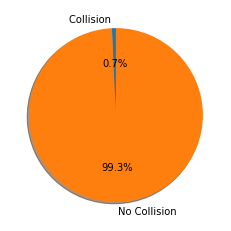

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv(training_dataset_root_path + "/db.csv") 

labels = 'Collision ', 'No Collision'
sizes = [data.loc[data['collision bool'] == 1].shape[0], data.loc[data['collision bool'] == 0].shape[0]]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

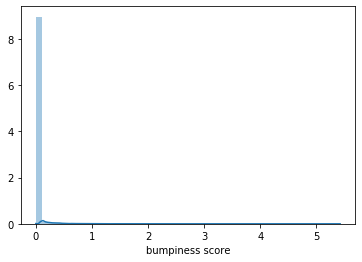

In [3]:
sns.distplot(data['bumpiness score'])

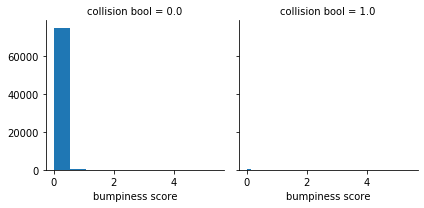

In [4]:
g = sns.FacetGrid(data, col="collision bool")
g.map(plt.hist, "bumpiness score");

### Dataset Object

In [5]:
import csv
import os

class BytesDataset:
    def __init__(self,  root_path):
        self.root_path = root_path
        self.dataset_left_imgs = os.path.join(self.root_path, "left")
        self.dataset_right_imgs = os.path.join(self.root_path, "right")
        self.dataset_file = os.path.join(self.root_path, "db.csv")
        self._read_db_file()
        
    def get_index_map(self):
        return self.index_map
    
    def get_left_images_path(self):
        return self.dataset_left_imgs 
    
    def get_right_images_path(self):
        return self.dataset_right_imgs 
    
    def get_db(self):
        return self.db_file
    
    def get_db_as_pd(self):
        return pd.read_csv(self.dataset_file, dtype={'stamp':str})
    
    def get_drive_command(self, row):
        return [self.get_db_value(row, 'action x'), self.get_db_value(row, 'action r')]
    
    def get_episode_indices(self):
        return self.episode_indicies
    
    def get_position(self, row):
        return [self.get_db_value(row, 'position x'), self.get_db_value(row, 'position y'), self.get_db_value(row, 'position z')]
    
    def get_orientation(self, row):
        return [self.get_db_value(row, 'odom orientation z'), self.get_db_value(row, 'odom orientation y'), self.get_db_value(row, 'odom orientation x'), self.get_db_value(row, 'odom orientation w')]
    
    def get_db_value(self, row, column):
        if type(column) == str:
            column = self.index_map[column]
        if column:
            return float(self.db_file[row][column])
        else: 
            return self.db_file[row][column]
    
    def _read_db_file(self):
        # Read the db file
        self.db_file = []
        # start and stops for each episode (zero to be replaced later) [inclusive, exclusive]
        self.episode_indicies = [[1,0]] 
        with open(self.dataset_file) as file:
            csv_reader = csv.reader(file)
            for i, row in enumerate(csv_reader):
                if(row[0] == "-"):
                    self.episode_indicies.append([i+1,0])
                    self.episode_indicies[len(self.episode_indicies)-2][1] = i
                self.db_file.append(row)
            if self.episode_indicies[len(self.episode_indicies)-1][1] == 0:
                self.episode_indicies[len(self.episode_indicies)-1][1] = len(self.db_file)
        self.index_map = dict(zip(self.db_file[0],range(len(self.db_file[0]))))
        
validation_data = BytesDataset(validation_dataset_root_path)
train_data = BytesDataset(training_dataset_root_path) 

print("Size of training set: ", len(train_data.get_db()))
print("Size of validation set: ", len(validation_data.get_db()))

Size of training set:  76453
Size of validation set:  3375


### Add functions for reading / augmenting images

In [6]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return torch.clamp(tensor + torch.randn(tensor.size()) * self.std + self.mean, min=0, max=1.0)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [7]:
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms

def process_image(img, augment=False):
    if augment:
        transform = transforms.Compose(
        [transforms.ColorJitter(0.5, 0.5, 0.5),
         transforms.RandomAffine(10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
         transforms.ToTensor(),
         AddGaussianNoise(0, 0.01),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # imagenet normalization
        ]) 
    else: 
        transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # imagenet normalization
        ]) 
    img = transform(Image.fromarray(img))
    return img 

def read_image(time_stamp, imgs_path, augment=False):
    img = plt.imread(os.path.join(imgs_path, time_stamp + ".jpg"))
    return process_image(img, augment)

image = read_image(train_data.get_db()[2][0], train_data.get_left_images_path())

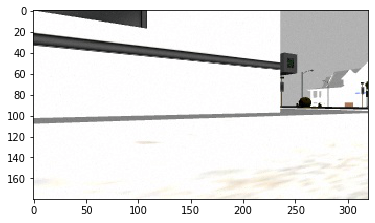

In [8]:
import numpy as np

def show_tensor_img(image):
    npimg = image.numpy().copy()
    # unnormalize the image
    npimg[0] *= 0.229
    npimg[1] *= 0.224
    npimg[2] *= 0.225
    npimg[0] += 0.485
    npimg[1] += 0.456
    npimg[2] += 0.406
    npimg = np.transpose(npimg, (1,2,0))
    return npimg

plt.imshow(show_tensor_img(image))

### Add functions for generating batches

In [9]:
import math
def kinematics_model(data, start_index, stop_index):
    # negative r is right
    path_est = []

    last_pose = [0,0,0] # x,y,yaw
    for i in range(start_index,stop_index+1):
        command = data.get_drive_command(i)
        dt = 0.2

        yaw = last_pose[2] + command[1]*dt
        x = last_pose[0] + command[0]*dt*math.sin(yaw)
        y = last_pose[1] + command[0]*dt*math.cos(yaw)

        last_pose = [x,y,yaw]

        path_est.append([-x,y])        
    return path_est

In [10]:
def quaternion_mult(q,r):
    return [r[0]*q[0]-r[1]*q[1]-r[2]*q[2]-r[3]*q[3],
            r[0]*q[1]+r[1]*q[0]-r[2]*q[3]+r[3]*q[2],
            r[0]*q[2]+r[1]*q[3]+r[2]*q[0]-r[3]*q[1],
            r[0]*q[3]-r[1]*q[2]+r[2]*q[1]+r[3]*q[0]]

# input point is [x,y,z] and quaternion is z, x, y, w
def point_rotation_by_quaternion(point,q):
    r = [0]+point
    q_conj = [q[0],-1*q[1],-1*q[2],-1*q[3]]
    return quaternion_mult(quaternion_mult(q,r),q_conj)[1:]

# point 1 - point 2
def subtract_points(point1, point2):
    return [point1[0] - point2[0], point1[1] - point2[1], point1[2] - point2[2]]

In [11]:
import random, os

# interesting data for making model deployment decisions
class BatchData:
    def __init__(self):
        self.max_y = -99999
        self.max_x = -99999
        self.avg_x = 0
        self.avg_y = 0
        self.total_x = 0
        self.total_y = 0
        self.min_y = 99999
        self.min_x = 99999
    def add_x_value(self, value):
        if value > self.max_x:
                self.max_x = value
        if value < self.min_x:
                self.min_x = value
        self.avg_x += value
        self.total_x += 1
    def add_y_value(self, value):
        if value > self.max_y:
            self.max_y = value
        if value < self.min_y:
            self.min_y = value
        self.avg_y += value
        self.total_y += 1
    def get_x_avg(self):
        return self.avg_x/self.total_x
    def get_y_avg(self):
        return self.avg_y/self.total_y
    
batch_data = BatchData()
        
def batch_generator(dataset, crop_shape=(3,20,20), image_shape=(3,180,320), collision_buffering=3, batch_size=16, max_forward_prediction=7, augmentation=False, batch_data=batch_data):
   
    index = 0
    dataset_pd = dataset.get_db_as_pd()
    breaks = dataset_pd.index[dataset_pd['stamp'] == '-']
    
    while True:
                
        left_images = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2]))
        right_images = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2]))
        
        left_crop = torch.zeros((batch_size, crop_shape[0], crop_shape[1], crop_shape[2]))
        right_crop = torch.zeros((batch_size, crop_shape[0], crop_shape[1], crop_shape[2]))
        
        positions = torch.zeros((batch_size, 2))
#         labels = torch.zeros((batch_size, 2))
        labels = torch.zeros((batch_size, 1))


        # Probability of explicitly grabbing specific "rare" events to train on 
        prob_collision = 0.2
        prob_bumpiness = 0.2
        
        i = 0
        while i < batch_size:
            
            rand = random.random()    
            
            source = 0
            target = 0
            
            if(rand < prob_collision):
                target = random.choice(dataset_pd.index[dataset_pd["collision bool"] > 0.1].tolist())    
            elif (rand < prob_collision + prob_bumpiness):
                target = random.choice(dataset_pd.index[dataset_pd["bumpiness score"] > 0.1].tolist())
            else:
                target = random.choice(dataset_pd.index[dataset_pd["stamp"] != '-'].tolist())
                
            nearest_break = 0
            try:
                nearest_break = breaks[(breaks < target)][-1]
            except:
                pass
            
            min_source = target - max_forward_prediction
            if nearest_break > target - max_forward_prediction:
                min_source = nearest_break + 1                
                        
            try:
                source = random.randint(min_source, target-1)
                
                target_position = [float(dataset_pd.iloc[target]['position x']), float(dataset_pd.iloc[target]['position y']), float(dataset_pd.iloc[target]['position z'])]
                source_position = [float(dataset_pd.iloc[source]['position x']), float(dataset_pd.iloc[source]['position y']), float(dataset_pd.iloc[target]['position z'])]
                # (row, 'odom orientation z'), self.get_db_value(row, 'odom orientation y'), self.get_db_value(row, 'odom orientation x'), self.get_db_value(row, 'odom orientation w')]
                source_orientation = [float(dataset_pd.iloc[source]['odom orientation z']), float(dataset_pd.iloc[source]['odom orientation y']), \
                                      float(dataset_pd.iloc[source]['odom orientation x']), float(dataset_pd.iloc[source]['odom orientation w'])]
                transformed_point = point_rotation_by_quaternion(subtract_points(source_position, target_position), source_orientation)

                bumpiness = float(dataset_pd.iloc[target]["bumpiness score"]) if float(dataset_pd.iloc[target]["bumpiness score"]) > 0.1 else 0
                collision = any((dataset_pd.iloc[target-collision_buffering:target+collision_buffering]["collision bool"] > 0.1).tolist())


                img_stamp = dataset_pd.iloc[source]["stamp"] if "." in dataset_pd.iloc[source]["stamp"] else dataset_pd.iloc[source]["stamp"] + "."
                
                # Get the patch that corresponds to where the robot will be in at the target        
                cameraMatrix=np.float64([[190.68123344056778, 0.0, 160.5], [0.0, 190.68123344056778, 90.5], [0.0, 0.0, 1.0]])
                tvec=np.float64([0.1485, 0.1, 0.1325])
                rvec=np.float64([-1.5707963, 1.5707963, 0 ])
                # to coordinate system x = z, y = constant, z = x
                point = [-transformed_point[1]+tvec[2], tvec[1], transformed_point[0]+tvec[0]]
                reprojected_point = np.matmul(cameraMatrix, point)
                pt_x = int(reprojected_point[0]/reprojected_point[2])
                pt_y = int(reprojected_point[1]/reprojected_point[2])
                
                left_image = read_image(img_stamp, dataset.get_left_images_path(), augment=augmentation)
                crop_left = left_image[:,pt_y-10:pt_y+10, pt_x-10:pt_x+10]
                
                cameraMatrix=np.float64([[190.68123344056778, 0.0, 160.5], [0.0, 190.68123344056778, 90.5], [0.0, 0.0, 1.0]])
                tvec=np.float64([0.1485, -0.1, 0.1325])
                rvec=np.float64([-1.5707963, 1.5707963, 0 ])
                # to coordinate system x = z, y = constant, z = x
                point = [-transformed_point[1]+tvec[2], tvec[1], transformed_point[0]+tvec[0]]
                reprojected_point = np.matmul(cameraMatrix, point)
                pt_x = int(reprojected_point[0]/reprojected_point[2])
                pt_y = int(reprojected_point[1]/reprojected_point[2])
                
                
                right_image = read_image(img_stamp, dataset.get_right_images_path(), augment=augmentation)
                crop_right = right_image[:,pt_y-10:pt_y+10, pt_x-10:pt_x+10]
        
                left_crop[i] = crop_left
                left_images[i] = left_image
                right_crop[i] = crop_right
                right_images[i] = right_image
                positions[i] = torch.tensor([-transformed_point[1], transformed_point[0]])
#                 labels[i] = torch.tensor([bumpiness, collision])
                labels[i] = torch.tensor([collision])

                
                # Update those interested variables for later analysis
                batch_data.add_x_value(-transformed_point[1])
                batch_data.add_y_value(transformed_point[0])
                
                i += 1
            except Exception as e:
                pass
            
        yield (left_images, left_crop, right_images, right_crop, positions, labels)            

In [12]:
gen = batch_generator(train_data, batch_size=16, max_forward_prediction=50)
left_images, left_crop, right_images, right_crop, positions, labels = next(gen)

print("Max x in batch : ", batch_data.max_x)
print("Min x in batch : ", batch_data.min_x)
print("Avg x in batch : ", batch_data.get_x_avg())
print("Max y in batch : ", batch_data.max_y)
print("Min y in batch : ", batch_data.min_y)
print("Avg y in batch : ", batch_data.get_y_avg())

Max x in batch :  1.5768614316825684
Min x in batch :  -2.240809435229391
Avg x in batch :  -0.19474049610144928
Max y in batch :  4.47663768755746
Min y in batch :  0.11278114043774523
Avg y in batch :  2.3901287341209945


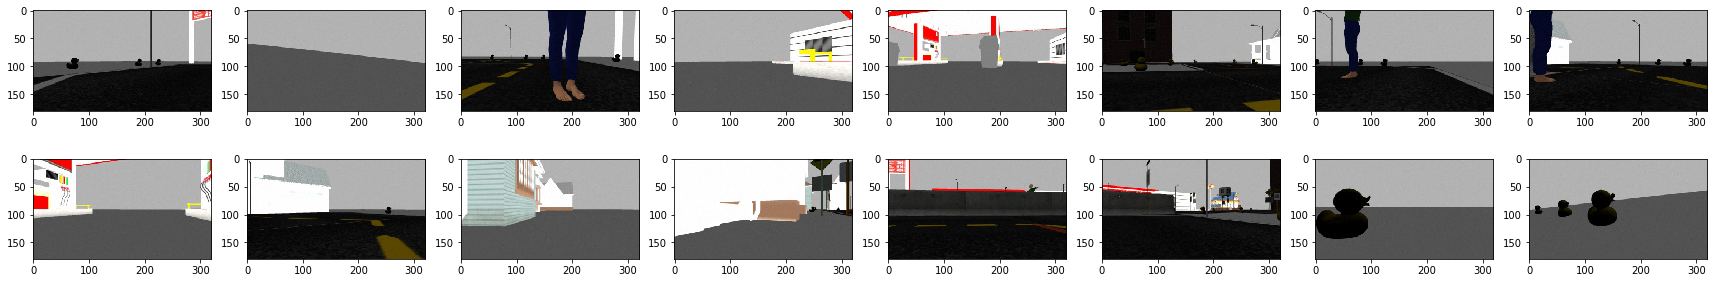

In [13]:
# Preview a batch

# Left Images
fig = plt.figure(figsize=(30,5))
for i in range(len(left_images)):
    fig.add_subplot(2, len(left_images)/2, i+1)
    plt.imshow(show_tensor_img(left_images[i]))

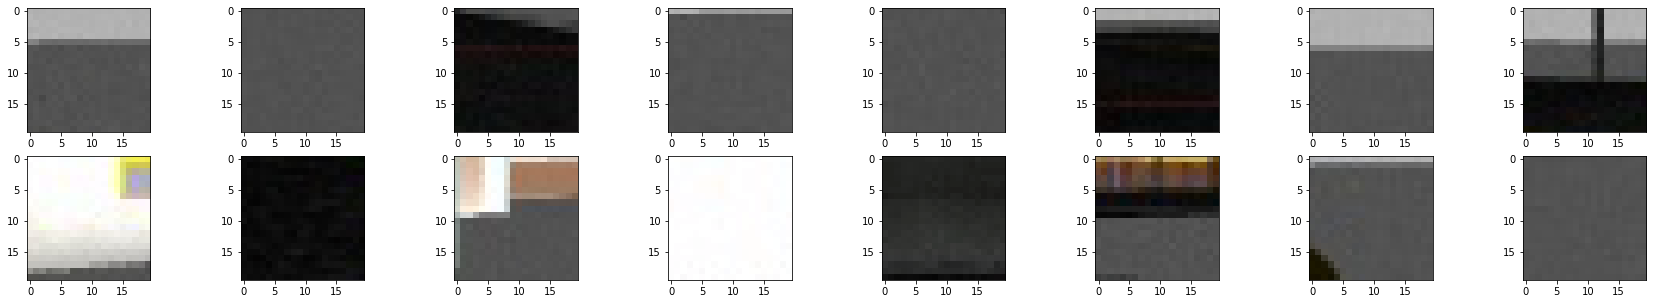

In [14]:
# Left Crop
fig = plt.figure(figsize=(30,5))
for i in range(len(left_crop)):
    fig.add_subplot(2, len(left_crop)/2, i+1)
    plt.imshow(show_tensor_img(left_crop[i]))

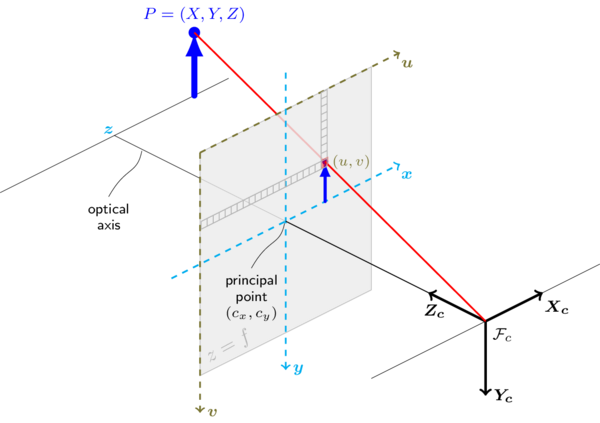

## Construct the Model

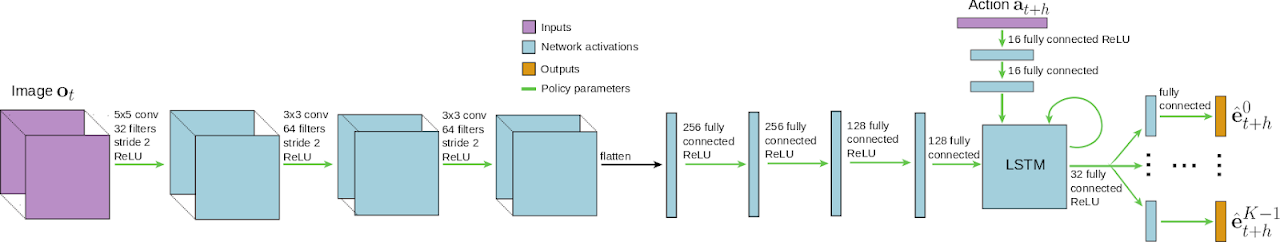

In [16]:
import torch.nn as nn
class NavNet(nn.Module):
    def __init__(self):
        super(NavNet, self).__init__()
        
        self.full_image_resnet = torchvision.models.resnet18(pretrained=True)
        self.full_image_resnet.fc = torch.nn.Linear(512, 20)
        
        self.crop_resnet = torchvision.models.resnet18(pretrained=True)
        self.crop_resnet.fc = torch.nn.Linear(512, 20)
        
        self.fc1 = nn.Linear(40, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, full_image, crop):
        x = F.relu(self.full_image_resnet(full_image))
        m = F.relu(self.crop_resnet(crop))
   
        x = torch.cat((x,m), 1)
                
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        
        return x

import torchvision
navnet = torchvision.models.resnet18()

In [17]:
import torchviz
navnet = NavNet()

In [129]:
test_batch_size = 5

test_crop = torch.rand((test_batch_size, 3,20,20))
print("Crop Image : ", test_crop.shape)

test_image = torch.rand((test_batch_size, 3,180,320))
print("Input Image : ", test_image.shape)

# test_actions = torch.rand((test_batch_size,2))
# print("Input Actions : ", test_actions.shape)

output = navnet(test_input, test_crop)
print("Output : ", output.shape)
print(output)

torchviz.make_dot(output).render("navnet", format="png")

print("\n#################")
print(navnet)
print("#################\n")
for i, param in enumerate(navnet.parameters()):
    print("Layer ", i, " has ", param.numel(), " parameters and is of shape ",  param.shape)
    if not param.requires_grad:
        print("Layer ", i, " does not have requires grad = true and will therefore be frozen")

Crop Image :  torch.Size([5, 3, 20, 20])
Input Image :  torch.Size([5, 3, 180, 320])
Output :  torch.Size([5, 1])
tensor([[0.4358],
        [0.4888],
        [0.4521],
        [0.4543],
        [0.4826]], grad_fn=<SigmoidBackward>)

#################
NavNet(
  (full_image_resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-0

## Training the model

In [130]:
from sklearn.metrics import accuracy_score


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


num_epochs = 200
steps_per_epoch = 50
validation_step_per_epoch = 10
batch_size = 16

max_forward_prediction = 50
collision_buffering = 3

train_generator = batch_generator(train_data, collision_buffering=collision_buffering, batch_size=batch_size, max_forward_prediction=max_forward_prediction, augmentation=False)
test_generator = batch_generator(validation_data, collision_buffering=collision_buffering, batch_size=batch_size, max_forward_prediction=max_forward_prediction, augmentation=False)

navnet.to(device)
pytorch_total_params = sum(p.numel() for p in navnet.parameters())
print("Model Size: ", pytorch_total_params)

optimizer = optim.Adam(navnet.parameters(), lr=1e-4)
criterion = nn.BCELoss()

train_loss = []
train_collision_acc = []
train_bumpiness_error = []
train_position_error = []

valid_loss = []
valid_collision_acc = []
valid_bumpiness_error = []
valid_position_error = []

for e in range(num_epochs):
    # train
    avg_loss = 0
    avg_collision_acc = 0
    avg_bumpiness_error = 0
    for s in range(steps_per_epoch):
        optimizer.zero_grad()

        left_images, left_crop, right_images, right_crop, positions, labels = next(train_generator)
                            
        output = navnet(left_images.to(device), left_crop.to(device))
                
#         loss = navnet.navnet_loss(output, labels.to(device))
        loss = criterion(output, labels.to(device))
        
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
        avg_collision_acc += accuracy_score(labels.cpu().numpy()[:,0], np.around(output.cpu().detach().numpy()[:,0]))
#         avg_bumpiness_error += np.linalg.norm(labels.cpu().numpy()[:,0] - output.cpu().detach().numpy()[:,0])
        
    avg_loss /= steps_per_epoch
    avg_collision_acc /= steps_per_epoch
    avg_bumpiness_error /= steps_per_epoch
    
    train_loss.append(avg_loss)
    train_collision_acc.append(avg_collision_acc)
    train_bumpiness_error.append(avg_bumpiness_error)
        
    print('Training epoch: %d, loss: %.3f, collision acc: %.3f, bumpiness error: %.3f' % (e, avg_loss, avg_collision_acc, avg_bumpiness_error))
    
    # validate
    avg_loss = 0
    avg_collision_acc = 0
    avg_bumpiness_error = 0
    for s in range(validation_step_per_epoch):
        left_images, left_crop, right_images, right_crop, positions, labels = next(test_generator)
        output = navnet(left_images.to(device), left_crop.to(device))
        
#         avg_loss += navnet.navnet_loss(output, labels.to(device)).item()
        avg_loss += criterion(output, labels.to(device)).item()

        avg_collision_acc += accuracy_score(labels.cpu().numpy()[:,0], np.around(output.cpu().detach().numpy()[:,0]))
#         avg_bumpiness_error += np.linalg.norm(labels.cpu().numpy()[:,0] - output.cpu().detach().numpy()[:,0])
        
    avg_loss /= validation_step_per_epoch
    avg_collision_acc /= validation_step_per_epoch
    avg_bumpiness_error /= validation_step_per_epoch
        
    valid_loss.append(avg_loss)
    valid_collision_acc.append(avg_collision_acc)
    valid_bumpiness_error.append(avg_bumpiness_error)
        
    print('Validating epoch: %d, loss: %.3f, collision acc: %.3f, bumpiness error: %.3f' % (e, avg_loss, avg_collision_acc, avg_bumpiness_error))

    
print('Finished Training')

PyTorch Version:  1.5.0
Torchvision Version:  0.6.0
cuda:0
Model Size:  22373965
Training epoch: 0, loss: 0.547, collision acc: 0.777, bumpiness error: 0.000
Validating epoch: 0, loss: 0.518, collision acc: 0.787, bumpiness error: 0.000
Training epoch: 1, loss: 0.442, collision acc: 0.807, bumpiness error: 0.000
Validating epoch: 1, loss: 0.487, collision acc: 0.775, bumpiness error: 0.000
Training epoch: 2, loss: 0.372, collision acc: 0.836, bumpiness error: 0.000
Validating epoch: 2, loss: 0.345, collision acc: 0.863, bumpiness error: 0.000
Training epoch: 3, loss: 0.387, collision acc: 0.829, bumpiness error: 0.000
Validating epoch: 3, loss: 0.395, collision acc: 0.838, bumpiness error: 0.000
Training epoch: 4, loss: 0.373, collision acc: 0.829, bumpiness error: 0.000
Validating epoch: 4, loss: 0.379, collision acc: 0.838, bumpiness error: 0.000
Training epoch: 5, loss: 0.359, collision acc: 0.851, bumpiness error: 0.000
Validating epoch: 5, loss: 0.317, collision acc: 0.887, bumpin

KeyboardInterrupt: 

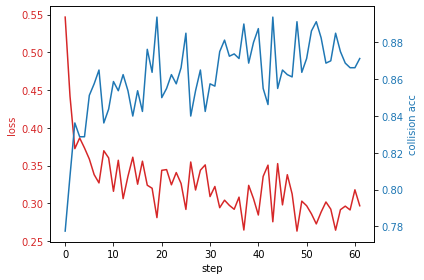

In [131]:
plot, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('step')
ax1.set_ylabel('loss', color=color)
ax1.plot(train_loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('collision acc', color=color)  # we already handled the x-label with ax1
ax2.plot(train_collision_acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plot.tight_layout()  # otherwise the right y-label is slightly clipped

Loss : collision acc : bumpiness l2 error


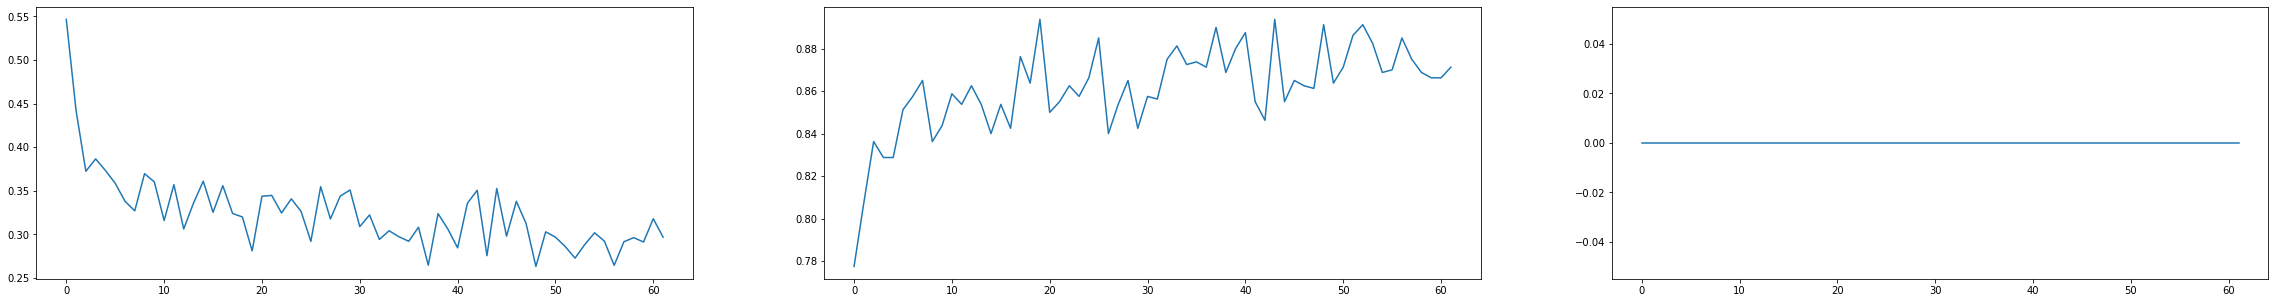

In [132]:
# Training Stats

fig = plt.figure(figsize=(40,5))
fig.add_subplot(1,3,1)
plt.plot(train_loss)
fig.add_subplot(1,3,2)
plt.plot(train_collision_acc)
fig.add_subplot(1,3,3)
plt.plot(train_bumpiness_error)

print("Loss : collision acc : bumpiness l2 error")

Loss : collision acc : bumpiness l2 error


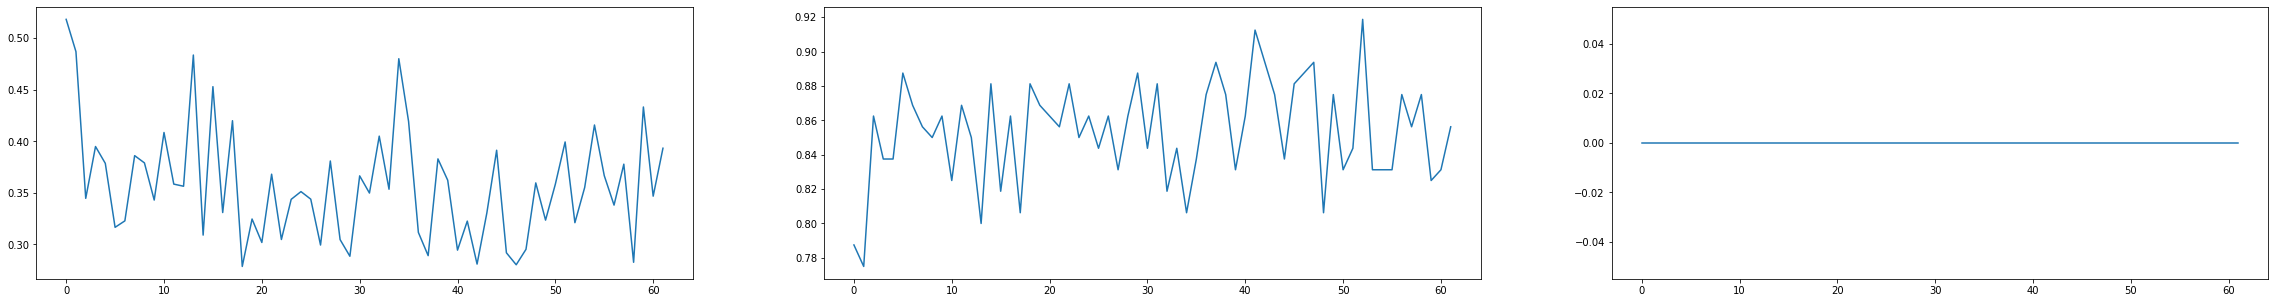

In [133]:
# Validation Stats

fig = plt.figure(figsize=(40,5))
fig.add_subplot(1,3,1)
plt.plot(valid_loss)
fig.add_subplot(1,3,2)
plt.plot(valid_collision_acc)
fig.add_subplot(1,3,3)
plt.plot(valid_bumpiness_error)
print("Loss : collision acc : bumpiness l2 error")

## Test the model

In [134]:
import cv2
def visualize_output(image, position, model_output, cameraMatrix=np.float64([[190.68123344056778, 0.0, 160.5], [0.0, 190.68123344056778, 90.5], [0.0, 0.0, 1.0]]), 
                     tvec=np.float64([0.1485, 0.1, 0.1325]), rvec=np.float64([-1.5707963, 1.5707963, 0 ]), img=[], print_stuff=True):
        
    # to coordinate system x = z, y = constant, z = x
    point = [position[0].item()+tvec[2], tvec[1], position[1].item()+tvec[0]]
    reprojected_point = np.matmul(cameraMatrix, point)
    
    if len(img) == 0:
        img = show_tensor_img(image).copy()
    
    color_mask = np.zeros((20,20,3), np.float32)
    red = np.zeros((20,20))
    red.fill(model_output.item())
    green = np.zeros((20,20))
    green.fill(1-model_output.item())
    color_mask[:,:,0] = red
    color_mask[:,:,1] = green
    img = cv2.addWeighted(img,0.7,color_mask,0.3,0)   
    plt.imshow(img)
    
    if print_stuff:
        pass
#         print("Collision Prob. : ", model_output[0].item())
#         print("Bumpiness Score. : ", model_output[0].item())

In [135]:
def label_to_output(label, index):
    return torch.cat((torch.tensor(label[2][index], dtype=torch.float32).unsqueeze(1),torch.tensor(label[1][index]).unsqueeze(1),torch.tensor(label[0][index])), axis=1)

### Eval model

In [136]:
train_generator = batch_generator(train_data, collision_buffering=3, batch_size=batch_size, max_forward_prediction=max_forward_prediction, augmentation=False)
test_generator = batch_generator(validation_data, collision_buffering=3, batch_size=batch_size, max_forward_prediction=max_forward_prediction, augmentation=False)
left_images, left_crop, right_images, right_crop, positions, labels = next(train_generator)

print("Input image size : ", left_images.shape)
print("Input positions size : ", positions.shape)
print("Labels dimensions : ", labels.shape )

Input image size :  torch.Size([16, 3, 180, 320])
Input positions size :  torch.Size([16, 2])
Labels dimensions :  torch.Size([16, 1])


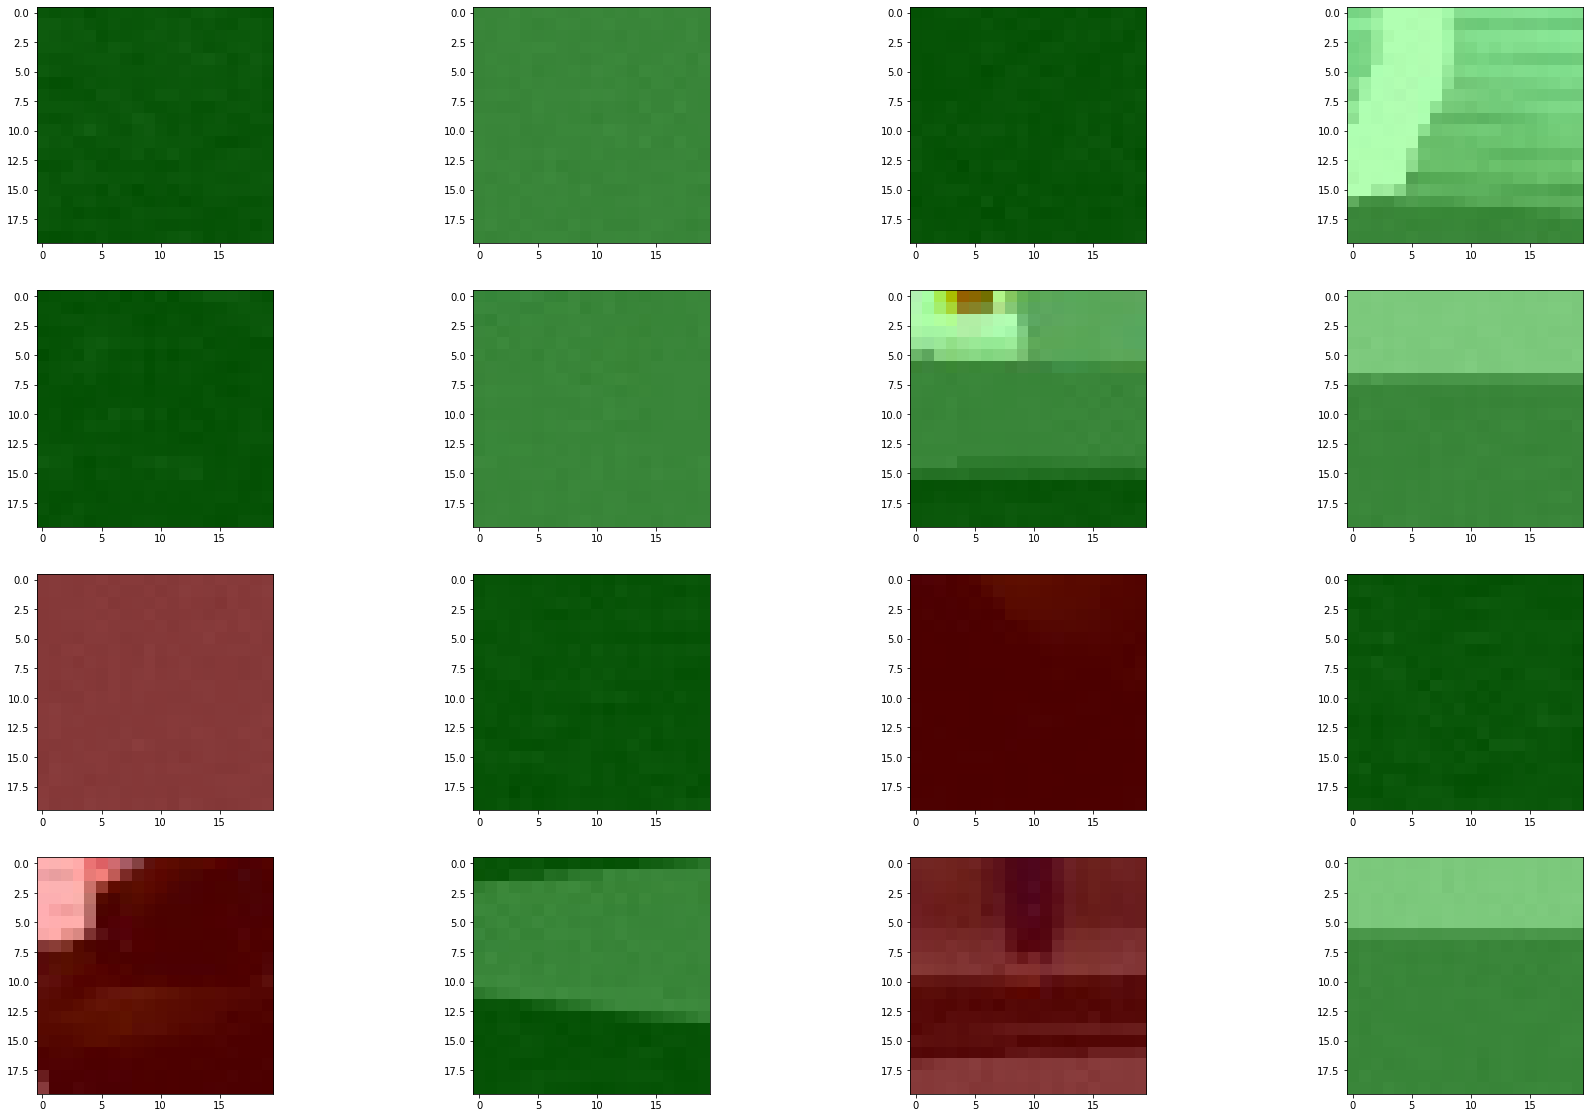

In [137]:
fig = plt.figure(figsize=(30,20))
num_images = 16
for i in range(num_images):
    fig.add_subplot(4,num_images/4,i+1)
    visualize_output(left_crop[i], positions[i], labels[i])

Ouput shape :  torch.Size([16, 1])


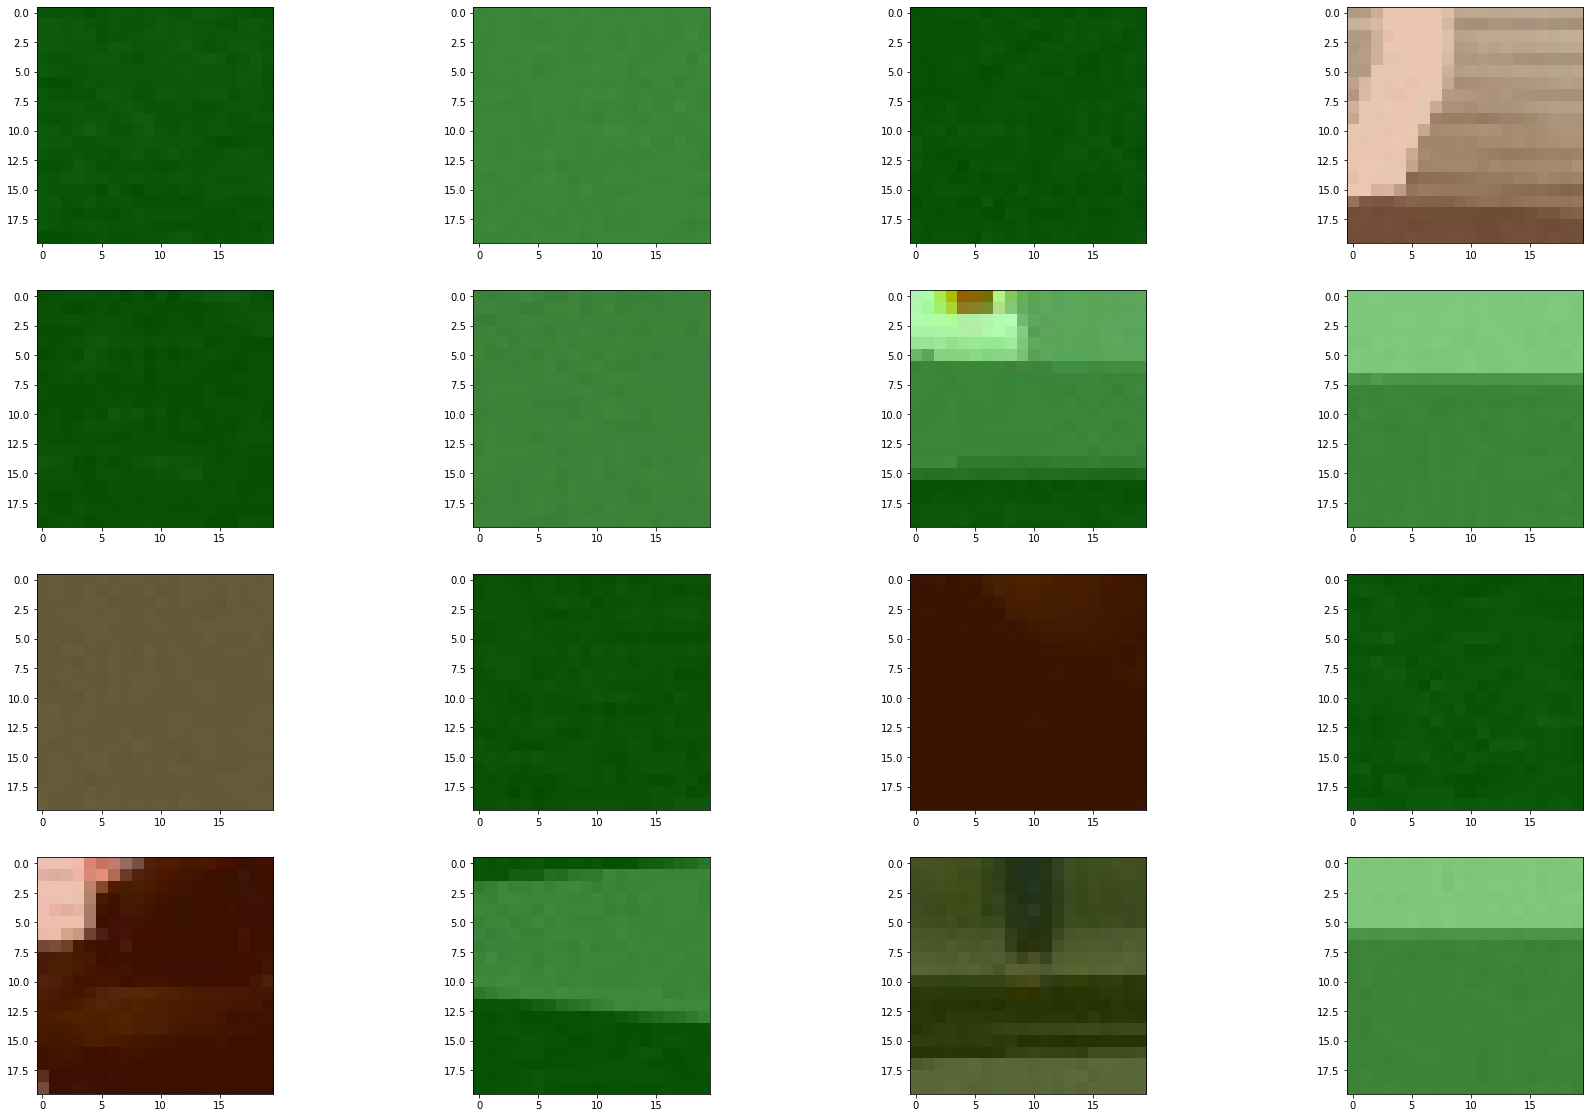

In [138]:
navnet.eval().to(device)

outputs = navnet(left_images.to(device), left_crop.to(device))

print("Ouput shape : ", outputs.shape)

fig = plt.figure(figsize=(30,20))
for i in range(num_images):
    fig.add_subplot(4,num_images/4,i+1)
    visualize_output(left_crop[i], positions[i], outputs[i])

### Applications Viewer

In [19]:
navnet.load_state_dict(torch.load("navnet-patch-predictor.pt"))

<All keys matched successfully>

In [1]:
import time, cv2
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

navnet.to(device)
for i in range(1, len(validation_data.get_db())):
    try:
        img = read_image(validation_data.get_db_value(i, 'stamp'), validation_data.get_right_images_path(), augment=False)
        cv_image = show_tensor_img(img)

        for width in range(0,320,20): # from 0 - 320
            for height in range(100, 180, 20): # from 100 - 180
                crop = img[:,height:height+20, width:width+20]
                crop_image = cv_image[height:height+20, width:width+20,:]
                model_output = navnet(img.unsqueeze(0).to(device), crop.unsqueeze(0).to(device))

                color_mask = np.zeros((20,20,3), np.float32)
                red = np.zeros((20,20))
                red.fill(model_output.item())
                green = np.zeros((20,20))
                green.fill(1-model_output.item())
                color_mask[:,:,0] = red
                color_mask[:,:,1] = green
                crop_image = cv2.addWeighted(crop_image,0.7,color_mask,0.3,0)  
                cv_image[height:height+20, width:width+20,:] = crop_image

        cv2.imshow('image', cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB))
        cv2.waitKey(1)
    except Exception as e:
        pass

NameError: name 'torch' is not defined

## Save the Model

In [140]:
# Standard pytorch model saving/loading
name = "navnet-patch-predictor"
torch.save(navnet.state_dict(), name + ".pt")
navnet.load_state_dict(torch.load(name + ".pt")) # test reloading model

<All keys matched successfully>

In [31]:
# Saving as pytorch jit for C++

example_image = torch.rand(1, 3, 180, 320)
exmaple_actions = torch.rand(1, 50, 2)

example_input = (example_image.to(device), exmaple_actions.to(device))

# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(navnet.to(device).eval(), example_input) # .eval() changes behavior of the batch norm layer so as not to require larger than 1 batch size
traced_script_module.save(name + "-traced.pt")

## TRTorch (not working yet)

In [479]:
import trtorch

torch_script_module = torch.jit.load('navnet-5-1-20-traced.pt')

compile_settings = {"input_shapes" : [[1, 3, 180, 320], [1,49,2]]}

trt_ts_module = trtorch.compile(torch_script_module, compile_settings)

# input_data = input_data.half()
result = trt_ts_module(example_input)

ModuleNotFoundError: No module named 'trtorch'